# ESG FUND ANALYSIS

In [2]:
import requests
from bs4 import BeautifulSoup
import re
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import time
import csv 
import os
import pickle
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import graphviz
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor # There is also a KerasClassifier class
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

!pip install openpyxl
import openpyxl
print("Library versions: pandas", pd.__version__," numpy", np.__version__," seaborn", sns.__version__)


Library versions: pandas 1.1.3  numpy 1.22.3  seaborn 0.11.0


In [3]:
def download_data():
    URL = 'https://fossilfreefunds.org/how-it-works'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    urls = []
    names = []
    for i, link in enumerate(soup.findAll('a')):
        FULLURL = link.get('href')
        if bool(re.search('.*results.*.xlsx', FULLURL)):
            urls.append(FULLURL)
            names.append(os.path.basename(soup.select('a')[i].attrs['href']))

    names_urls = zip(names, urls)
    for name, url in names_urls:
        print("Download file: "+name)
        r = requests.get(url, verify=False,stream=True)
        r.raw.decode_content = True
        with open("/kaggle/working/" + name, 'wb') as out:
                shutil.copyfileobj(r.raw, out)    

def merge_excel():
    df = pd.DataFrame()
    files=os.listdir('data') 
    files_xls = [f for f in files if f[-4:]=='xlsx']

    for f in files_xls:
        if not re.match(r".*20210[5-9]+.*", f):
            print('Merging file: '+f)
            data = pd.read_excel('data/'+f, 'Shareclasses',engine='openpyxl')
            df = df.append(data) 
    df.to_csv('/kaggle/working/fossilfund_dataset.csv', index=False)
    print('Export to data/fossilfund_dataset.csv is finished')

#No download ncessary for this notebook, use of Kaggle dataset directly
#if not os.path.exists('data'):
#    os.makedirs('data')
#    download_data()
#    merge_excel()

In [4]:
df = pd.read_csv('fossilfund_dataset.csv')

C:\Users\19492\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df.head()


,Fund profile: Shareclass name,Fund profile: Ticker,Fund profile: Fund name,Fund profile: Asset manager,Fund profile: Shareclass type,Fund profile: Shareclass inception date,Fund profile: Category group,Fund profile: Sustainability mandate,Fund profile: US-SIF member,Fund profile: Oldest shareclass inception date,...,"Prison Free Funds: Border industry, higher risk, weight","Prison Free Funds: Border industry, higher risk, asset","Prison Free Funds: Private prison operators, count","Prison Free Funds: Private prison operators, weight","Prison Free Funds: Private prison operators, asset",Gender Equality Funds: Gender equality score - Overall score (out of 100 points),Gender Equality Funds: Gender equality score - Gender balance in leadership and workforce (out of 40 points),Gender Equality Funds: Gender equality score - Equal compensation and work life balance (out of 30 points),Gender Equality Funds: Gender equality score - Policies promoting gender equality (out of 20 points),"Gender Equality Funds: Gender equality score - Commitment, transparency, and accountability (out of 10 points)"
0,1290 SmartBeta Equity A,TNBRX,1290 SmartBeta Equity Fund,1290 Funds,Open-end mutual fund,2014-11-12,International Equity Funds,Y,NaN,2014-11-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1290 SmartBeta Equity I,TNBRX,1290 SmartBeta Equity Fund,1290 Funds,Open-end mutual fund,2014-11-12,International Equity Funds,Y,NaN,2014-11-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1290 SmartBeta Equity R,TNBRX,1290 SmartBeta Equity Fund,1290 Funds,Open-end mutual fund,2014-11-12,International Equity Funds,Y,NaN,2014-11-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1290 SmartBeta Equity T,TNBRX,1290 SmartBeta Equity Fund,1290 Funds,Open-end mutual fund,2014-11-12,International Equity Funds,Y,NaN,2014-11-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13D Activist A,DDDCX,13D Activist Fund,13D Activist Fund,Open-end mutual fund,2011-12-28,U.S. Equity Fund,Y,NaN,2011-12-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
date_cols=df.filter(regex=" date.*",axis=1).columns
df[date_cols]=df[date_cols].apply(pd.to_datetime, errors='coerce')
df[date_cols]

,Fund profile: Shareclass inception date,Fund profile: Oldest shareclass inception date,Fund profile: Portfolio holdings as-of date,Financial performance: Financial performance as-of date
0,2014-11-12,2014-11-12,2020-01-31,2020-03-31
1,2014-11-12,2014-11-12,2020-01-31,2020-03-31
2,2014-11-12,2014-11-12,2020-01-31,2020-03-31
3,2014-11-12,2014-11-12,2020-01-31,2020-03-31
4,2011-12-28,2011-12-28,2019-12-31,2020-03-31
...,...,...,...,...
110505,2018-12-04,2018-12-04,2021-02-28,2021-02-28
110506,2018-09-05,2018-09-05,2021-02-28,2021-02-28
110507,2018-12-04,2018-12-04,2021-02-28,2021-02-28
110508,2019-03-06,2019-03-06,2021-02-28,2021-02-28


In [9]:
display(HTML(df[0:10].to_html())) 

,Fund profile: Shareclass name,Fund profile: Ticker,Fund profile: Fund name,Fund profile: Asset manager,Fund profile: Shareclass type,Fund profile: Shareclass inception date,Fund profile: Category group,Fund profile: Sustainability mandate,Fund profile: US-SIF member,Fund profile: Oldest shareclass inception date,Fund profile: Shareclass tickers,Fund profile: Portfolio holdings as-of date,Fund profile: Fund net assets,Fund profile: Percent rated,Fossil Free Funds: Fossil fuel grade,"Fossil Free Funds: Fossil fuel holdings, count","Fossil Free Funds: Fossil fuel holdings, weight","Fossil Free Funds: Fossil fuel holdings, asset","Fossil Free Funds: Carbon Underground 200, count","Fossil Free Funds: Carbon Underground 200, weight","Fossil Free Funds: Carbon Underground 200, asset","Fossil Free Funds: Coal industry, count","Fossil Free Funds: Coal industry, weight","Fossil Free Funds: Coal industry, asset","Fossil Free Funds: Oil / gas industry, count","Fossil Free Funds: Oil / gas industry, weight","Fossil Free Funds: Oil / gas industry, asset","Fossil Free Funds: Macroclimate 30 coal-fired utilities, count","Fossil Free Funds: Macroclimate 30 coal-fired utilities, weight","Fossil Free Funds: Macroclimate 30 coal-fired utilities, asset","Fossil Free Funds: Fossil-fired utilities, count","Fossil Free Funds: Fossil-fired utilities, weight","Fossil Free Funds: Fossil-fired utilities, asset",Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested),Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue),Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e),Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e),Fossil Free Funds: Carbon footprint portfolio coverage by market value weight,Fossil Free Funds: Carbon footprint portfolio coverage by number of disclosing titles,"Fossil Free Funds: Clean200, count","Fossil Free Funds: Clean200, weight","Fossil Free Funds: Clean200, asset",Deforestation Free Funds: Deforestation grade,"Deforestation Free Funds: Deforestation-risk producer, count","Deforestation Free Funds: Deforestation-risk producer, weight","Deforestation Free Funds: Deforestation-risk producer, asset","Deforestation Free Funds: Deforestation-risk financier, count","Deforestation Free Funds: Deforestation-risk financier, weight","Deforestation Free Funds: Deforestation-risk financier, asset","Deforestation Free Funds: Deforestation-risk consumer brand, count","Deforestation Free Funds: Deforestation-risk consumer brand, weight","Deforestation Free Funds: Deforestation-risk consumer brand, asset",Gender Equality Funds: Gender equality grade,Gender Equality Funds: Gender equality group ranking,Gender Equality Funds: Gender equality score (out of 100 points),"Gender Equality Funds: Gender equality score, gender balance (out of 100 points)","Gender Equality Funds: Gender equality score, gender policies (out of 100 points)",Gender Equality Funds: Count of holdings with Equileap gender equality scores,Gender Equality Funds: Weight of holdings with Equileap gender equality scores,Gun Free Funds: Civilian firearm grade,"Gun Free Funds: Civilian firearm, count","Gun Free Funds: Civilian firearm, weight","Gun Free Funds: Civilian firearm, asset","Gun Free Funds: Gun manufacturer, count","Gun Free Funds: Gun manufacturer, weight","Gun Free Funds: Gun manufacturer, asset","Gun Free Funds: Gun retailer, count","Gun Free Funds: Gun retailer, weight","Gun Free Funds: Gun retailer, asset",Weapon Free Funds: Military weapon grade,"Weapon Free Funds: Military weapon, count","Weapon Free Funds: Military weapon, weight","Weapon Free Funds: Military weapon, asset","Weapon Free Funds: Major military contractors, count","Weapon Free Funds: Major military contractors, weight","Weapon Free Funds: Major military contractors, asset","Weapon Free Funds: Nuclear weapons, count","Weapon Free Funds: Nuclear weapons, weight","Weapon Free Funds: Nuclear weapons, asset","Weapon Free Funds: Cluste

In [11]:
#create variables for each group and display information separately
#Our target value has to be 1-y as it is the most complete => need to show fill factor
#display(HTML(    .to_html())) 
origin_categories=["Fund profile","Fossil Free Funds", "Deforestation Free Funds", "Gender Equality Funds", "Gun Free Funds", "Prison Free Funds", "Weapon Free Funds", "Tobacco Free Funds", "Financial performance"]
for category in origin_categories:
    print("Distribution of numerical features for category: "+category)
    display(HTML(df.filter(regex=category+".*",axis=1).describe().to_html())) 
    print("\n\n")

Distribution of numerical features for category: Fund profile


,Fund profile: Fund net assets,Fund profile: Percent rated
count,1.105100e+05,110510.000000
mean,7.421210e+09,0.943398
std,3.493070e+10,0.105523
min,1.534680e+05,0.400349
25%,2.025332e+08,0.951903
50%,8.267780e+08,0.977816
75%,3.094538e+09,0.991256
max,1.075580e+12,1.000000





Distribution of numerical features for category: Fossil Free Funds


,"Fossil Free Funds: Fossil fuel holdings, count","Fossil Free Funds: Fossil fuel holdings, weight","Fossil Free Funds: Fossil fuel holdings, asset","Fossil Free Funds: Carbon Underground 200, count","Fossil Free Funds: Carbon Underground 200, weight","Fossil Free Funds: Carbon Underground 200, asset","Fossil Free Funds: Coal industry, count","Fossil Free Funds: Coal industry, weight","Fossil Free Funds: Coal industry, asset","Fossil Free Funds: Oil / gas industry, count","Fossil Free Funds: Oil / gas industry, weight","Fossil Free Funds: Oil / gas industry, asset","Fossil Free Funds: Macroclimate 30 coal-fired utilities, count","Fossil Free Funds: Macroclimate 30 coal-fired utilities, weight","Fossil Free Funds: Macroclimate 30 coal-fired utilities, asset","Fossil Free Funds: Fossil-fired utilities, count","Fossil Free Funds: Fossil-fired utilities, weight","Fossil Free Funds: Fossil-fired utilities, asset",Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested),Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue),Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e),Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e),Fossil Free Funds: Carbon footprint portfolio coverage by market value weight,Fossil Free Funds: Carbon footprint portfolio coverage by number of disclosing titles,"Fossil Free Funds: Clean200, count","Fossil Free Funds: Clean200, weight","Fossil Free Funds: Clean200, asset"
count,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,1.105100e+05,110510.000000,110510.000000,110510.000000,110510.000000,1.105100e+05
mean,16.776328,0.066618,4.559884e+08,5.080291,0.022519,1.625754e+08,2.051154,0.005956,3.603254e+07,8.966329,0.035334,2.135207e+08,1.287892,0.007629,8.170273e+07,7.065207,0.030147,2.397661e+08,120.149909,167.592131,8.104975e+05,2.531491e+06,0.902381,0.538557,9.926513,0.074519,6.763798e+08
std,36.225283,0.120382,2.416856e+09,10.294005,0.055667,8.644581e+08,7.080570,0.014675,2.952930e+08,19.619299,0.097442,1.100159e+09,2.575200,0.018861,6.400949e+08,16.051047,0.063305,1.387114e+09,139.569661,194.430358,4.049854e+06,1.285494e+07,0.114800,0.260548,16.027081,0.065907,3.597203e+09
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,0.004361,4.081950e+05,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,27.830000,64.202500,1.241923e+04,4.403967e+04,0.890223,0.360000,2.000000,0.017976,2.929204e+06
50%,6.000000,0.042483,1.946916e+07,2.000000,0.009438,2.591610e+06,0.000000,0.000000,0.000000e+00,3.000000,0.017249,7.172282e+06,0.000000,0.000000,0.000000e+00,2.000000,0.018291,5.568960e+06,81.785000,126.530000,6.703449e+04,2.268255e+05,0.939559,0.574074,5.000000,0.067256,3.527957e+07
75%,17.000000,0.081263,1.132204e+08,5.000000,0.027531,3.265208e+07,1.000000,0.005303,3.014772e+06,8.000000,0.038630,5.082529e+07,1.000000,0.008828,6.446923e+06,7.000000,0.040002,4.873230e+07,160.680000,206.030000,2.557974e+05,8.391097e+05,0.967733,0.756972,11.000000,0.109732,2.058332e+08
max,607.000000,1.000000,6.561243e+10,154.000000,0.987275,2.145536e+10,126.000000,0.430865,9.675759e+09,304.000000,1.000000,2.751784e+10,31.000000,0.318989,2.000770e+10,286.000000,0.970667,3.884303e+10,1911.540000,3279.730000,8.837339e+07,3.252584e+08,0.999999,1.000000,210.000000,0.563840,1.246118e+11





Distribution of numerical features for category: Deforestation Free Funds


,"Deforestation Free Funds: Deforestation-risk producer, count","Deforestation Free Funds: Deforestation-risk producer, weight","Deforestation Free Funds: Deforestation-risk producer, asset","Deforestation Free Funds: Deforestation-risk financier, count","Deforestation Free Funds: Deforestation-risk financier, weight","Deforestation Free Funds: Deforestation-risk financier, asset","Deforestation Free Funds: Deforestation-risk consumer brand, count","Deforestation Free Funds: Deforestation-risk consumer brand, weight","Deforestation Free Funds: Deforestation-risk consumer brand, asset"
count,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05
mean,1.721220,0.004834,2.564535e+07,2.012243,0.015636,1.282902e+08,9.727002,0.071461,6.741212e+08
std,5.511702,0.012479,1.759466e+08,4.113846,0.026991,7.845226e+08,14.396919,0.070912,4.192372e+09
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.000000,0.012772,2.040628e+06
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,5.000000,0.057369,3.039811e+07
75%,1.000000,0.005083,2.831012e+06,3.000000,0.023091,2.211200e+07,11.000000,0.117454,1.926315e+08
max,97.000000,0.419285,5.494813e+09,44.000000,0.458033,2.398488e+10,170.000000,0.769213,1.361574e+11





Distribution of numerical features for category: Gender Equality Funds


,Gender Equality Funds: Gender equality group ranking,Gender Equality Funds: Gender equality score (out of 100 points),"Gender Equality Funds: Gender equality score, gender balance (out of 100 points)","Gender Equality Funds: Gender equality score, gender policies (out of 100 points)",Gender Equality Funds: Count of holdings with Equileap gender equality scores,Gender Equality Funds: Weight of holdings with Equileap gender equality scores,Gender Equality Funds: Gender equality score - Overall score (out of 100 points),Gender Equality Funds: Gender equality score - Gender balance in leadership and workforce (out of 40 points),Gender Equality Funds: Gender equality score - Equal compensation and work life balance (out of 30 points),Gender Equality Funds: Gender equality score - Policies promoting gender equality (out of 20 points),"Gender Equality Funds: Gender equality score - Commitment, transparency, and accountability (out of 10 points)"
count,107248.000000,55648.000000,55648.000000,55648.000000,110510.000000,110510.000000,54602.000000,54602.000000,54602.000000,54602.000000,54602.000000
mean,51.667925,47.846967,38.615098,65.649026,148.063171,0.865151,37.575016,17.966705,4.694791,14.602872,0.205304
std,28.294964,11.134500,11.948504,15.257334,230.042228,0.193753,8.238707,4.164146,2.462446,2.299153,0.408077
min,-1.000000,-5.000000,-1.000000,-1.000000,-1.000000,0.000000,8.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,39.000000,29.000000,58.000000,45.000000,0.846149,31.000000,15.000000,2.000000,13.000000,0.000000
50%,53.000000,52.000000,42.000000,71.000000,70.000000,0.954844,40.000000,19.000000,5.000000,15.000000,0.000000
75%,76.000000,57.000000,48.000000,76.000000,149.000000,0.982787,44.000000,21.000000,6.000000,16.000000,0.000000
max,100.000000,71.000000,67.000000,90.000000,3549.000000,1.000000,57.000000,29.000000,14.000000,19.000000,2.000000





Distribution of numerical features for category: Gun Free Funds


,"Gun Free Funds: Civilian firearm, count","Gun Free Funds: Civilian firearm, weight","Gun Free Funds: Civilian firearm, asset","Gun Free Funds: Gun manufacturer, count","Gun Free Funds: Gun manufacturer, weight","Gun Free Funds: Gun manufacturer, asset","Gun Free Funds: Gun retailer, count","Gun Free Funds: Gun retailer, weight","Gun Free Funds: Gun retailer, asset"
count,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05
mean,0.367134,0.002291,1.476360e+07,0.133997,0.000233,5.793564e+05,0.233137,0.002059,1.418425e+07
std,0.976743,0.006541,1.760328e+08,0.622026,0.001626,6.528876e+06,0.520607,0.006356,1.726770e+08
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
75%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
max,9.000000,0.123578,6.422196e+09,5.000000,0.059507,2.388009e+08,4.000000,0.123578,6.234913e+09





Distribution of numerical features for category: Prison Free Funds


,"Prison Free Funds: All flagged, count","Prison Free Funds: All flagged, weight","Prison Free Funds: All flagged, asset","Prison Free Funds: Prison industry, count","Prison Free Funds: Prison industry, weight","Prison Free Funds: Prison industry, asset","Prison Free Funds: Border industry, count","Prison Free Funds: Border industry, weight","Prison Free Funds: Border industry, asset","Prison Free Funds: All flagged, higher risk, count","Prison Free Funds: All flagged, higher risk, weight","Prison Free Funds: All flagged, higher risk, asset","Prison Free Funds: Prison industry, higher risk, count","Prison Free Funds: Prison industry, higher risk, weight","Prison Free Funds: Prison industry, higher risk, asset","Prison Free Funds: Border industry, higher risk, count","Prison Free Funds: Border industry, higher risk, weight","Prison Free Funds: Border industry, higher risk, asset","Prison Free Funds: Private prison operators, count","Prison Free Funds: Private prison operators, weight","Prison Free Funds: Private prison operators, asset"
count,73327.000000,73327.000000,7.332700e+04,73327.000000,73327.000000,7.332700e+04,73327.000000,73327.000000,7.332700e+04,73327.000000,73327.000000,7.332700e+04,73327.00000,73327.000000,7.332700e+04,73327.000000,73327.000000,7.332700e+04,73327.000000,73327.000000,7.332700e+04
mean,4.025339,0.053004,7.014752e+08,1.860720,0.014355,1.502954e+08,3.279215,0.049007,6.582665e+08,1.282720,0.007317,9.458700e+07,0.30979,0.000973,5.739907e+06,1.108923,0.006691,8.982786e+07,0.158536,0.000445,1.456922e+06
std,5.600233,0.064048,4.721844e+09,2.889954,0.023717,1.062010e+09,4.510981,0.061891,4.407261e+09,2.039754,0.014349,5.406483e+08,0.80476,0.004256,4.374918e+07,1.838222,0.013961,5.344365e+08,0.570387,0.003249,1.548875e+07
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
50%,2.000000,0.017992,1.094116e+07,1.000000,0.003490,6.321090e+05,2.000000,0.014145,6.961842e+06,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
75%,6.000000,0.094693,1.396684e+08,3.000000,0.019737,2.824184e+07,5.000000,0.088201,1.147099e+08,2.000000,0.010257,1.240795e+07,0.00000,0.000000,0.000000e+00,2.000000,0.009384,9.794897e+06,0.000000,0.000000,0.000000e+00
max,46.000000,0.581728,1.484406e+11,35.000000,0.363807,3.999880e+10,36.000000,0.581728,1.335580e+11,20.000000,0.488611,1.429152e+10,10.00000,0.111841,1.066400e+09,15.000000,0.488611,1.411504e+10,7.000000,0.099286,4.031889e+08





Distribution of numerical features for category: Weapon Free Funds


,"Weapon Free Funds: Military weapon, count","Weapon Free Funds: Military weapon, weight","Weapon Free Funds: Military weapon, asset","Weapon Free Funds: Major military contractors, count","Weapon Free Funds: Major military contractors, weight","Weapon Free Funds: Major military contractors, asset","Weapon Free Funds: Nuclear weapons, count","Weapon Free Funds: Nuclear weapons, weight","Weapon Free Funds: Nuclear weapons, asset","Weapon Free Funds: Cluster munitions / landmines, count","Weapon Free Funds: Cluster munitions / landmines, weight","Weapon Free Funds: Cluster munitions / landmines, asset"
count,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05
mean,3.294833,0.016616,1.823725e+08,3.253163,0.016549,1.821343e+08,1.602000,0.009491,1.296912e+08,0.037743,0.000015,6.391814e+04
std,5.221361,0.025743,9.427030e+08,5.147298,0.025762,9.424386e+08,2.556526,0.018837,7.131973e+08,0.365929,0.000218,1.270657e+06
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
50%,1.000000,0.011855,5.140992e+06,1.000000,0.011795,4.903307e+06,1.000000,0.000927,7.446500e+04,0.000000,0.000000,0.000000e+00
75%,4.000000,0.025795,4.442682e+07,4.000000,0.025757,4.355494e+07,2.000000,0.015139,1.719410e+07,0.000000,0.000000,0.000000e+00
max,66.000000,0.860331,2.723234e+10,63.000000,0.860331,2.723234e+10,23.000000,0.687890,1.928129e+10,7.000000,0.009169,5.162492e+07





Distribution of numerical features for category: Tobacco Free Funds


,"Tobacco Free Funds: Tobacco producer, count","Tobacco Free Funds: Tobacco producer, weight","Tobacco Free Funds: Tobacco producer, asset","Tobacco Free Funds: Tobacco-promoting entertainment company, count","Tobacco Free Funds: Tobacco-promoting entertainment company, weight","Tobacco Free Funds: Tobacco-promoting entertainment company, asset"
count,110510.000000,110510.000000,1.105100e+05,110510.000000,110510.000000,1.105100e+05
mean,0.792019,0.005017,7.821135e+07,0.710325,0.007367,8.063425e+07
std,1.497490,0.011223,4.810194e+08,1.207540,0.014824,6.045201e+08
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
75%,1.000000,0.005041,2.672713e+06,1.000000,0.010001,6.559704e+06
max,19.000000,0.140505,5.913728e+09,8.000000,0.224224,2.237722e+10





Distribution of numerical features for category: Financial performance


,"Financial performance: Month end trailing returns, year 1","Financial performance: Month end trailing returns, year 3","Financial performance: Month end trailing returns, year 5","Financial performance: Month end trailing returns, year 10"
count,108367.000000,103448.000000,96542.000000,81748.000000
mean,8.354840,6.455049,8.315809,9.381584
std,20.709696,8.775643,7.034999,4.877457
min,-79.657770,-50.617880,-39.775530,-25.167160
25%,-5.553780,0.870672,3.775177,6.437010
50%,5.761320,5.415205,7.775750,9.396265
75%,19.653715,11.350495,12.442040,12.601810
max,237.930500,71.112440,54.301480,24.884430


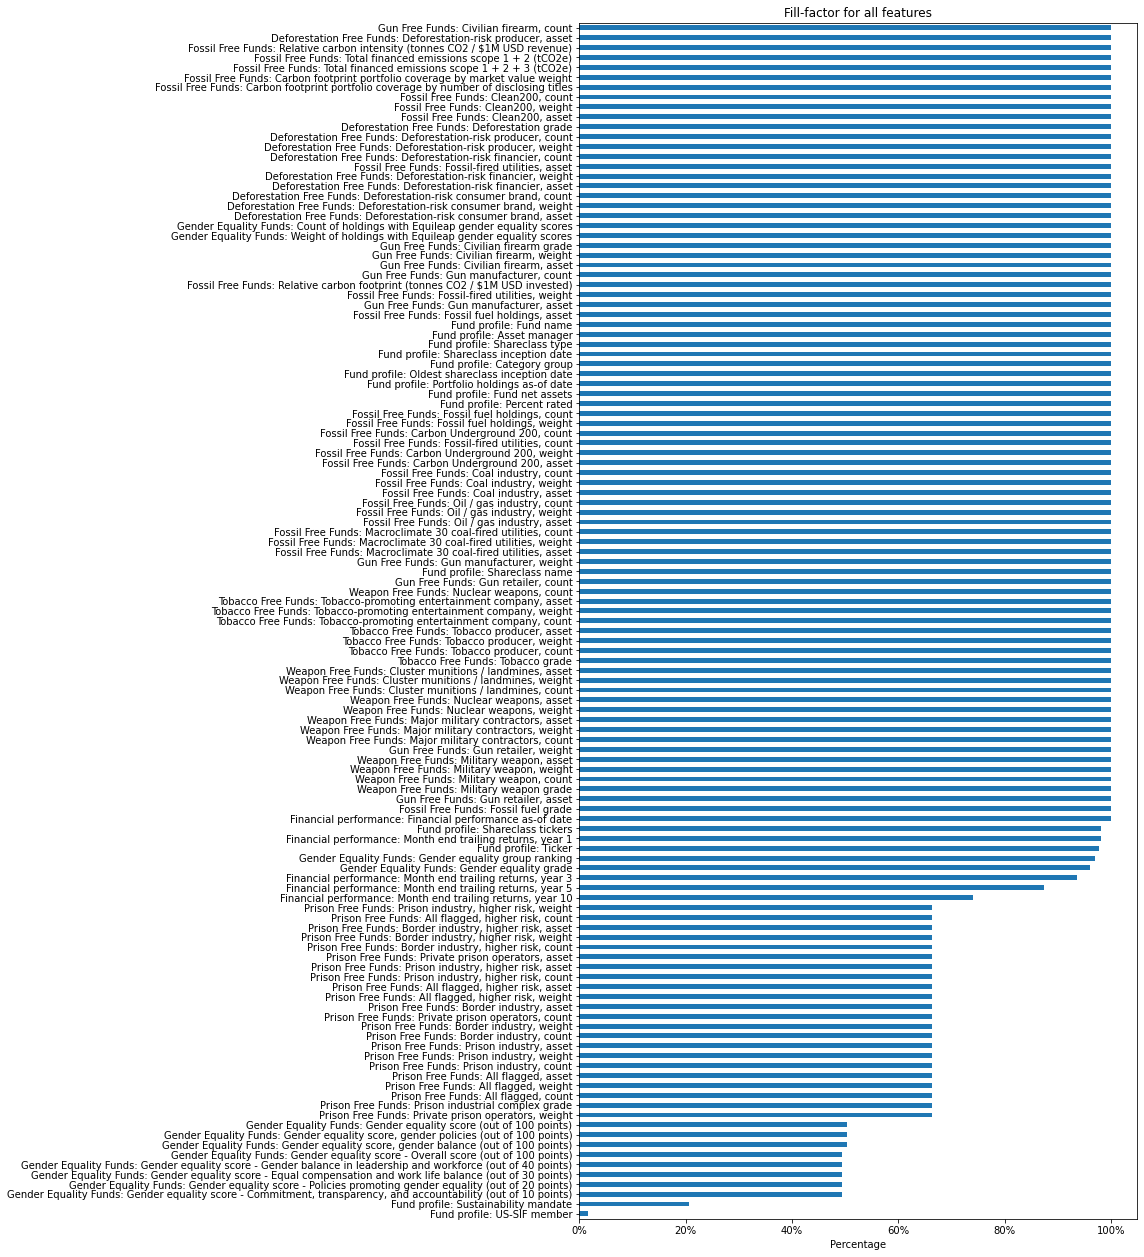

In [12]:
columns_stats=pd.DataFrame()
columns_stats['fill_percent']=df.notnull().sum(axis=0)/len(df)*100
fig = plt.figure(figsize=(10, 22))
columns_stats['fill_percent'].sort_values().plot.barh()
plt.title("Fill-factor for all features")
plt.xlabel("Percentage")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()


## drop with less than 50% of data completeness

In [14]:
columns_stats[columns_stats['fill_percent']<50]

,fill_percent
Fund profile: Sustainability mandate,20.634332
Fund profile: US-SIF member,1.544657
Gender Equality Funds: Gender equality score - Overall score (out of 100 points),49.409103
Gender Equality Funds: Gender equality score - Gender balance in leadership and workforce (out of 40 points),49.409103
Gender Equality Funds: Gender equality score - Equal compensation and work life balance (out of 30 points),49.409103
Gender Equality Funds: Gender equality score - Policies promoting gender equality (out of 20 points),49.409103
"Gender Equality Funds: Gender equality score - Commitment, transparency, and accountability (out of 10 points)",49.409103


In [17]:
df.drop(columns=columns_stats[columns_stats['fill_percent']<60].index.values.tolist(), axis=1, inplace=True)

## select the target with top financial performance

In [19]:
columns_stats['fill_percent'].filter(regex="Financial performance.*")

Financial performance: Financial performance as-of date       99.994571
Financial performance: Month end trailing returns, year 1     98.060809
Financial performance: Month end trailing returns, year 3     93.609628
Financial performance: Month end trailing returns, year 5     87.360420
Financial performance: Month end trailing returns, year 10    73.973396
Name: fill_percent, dtype: float64

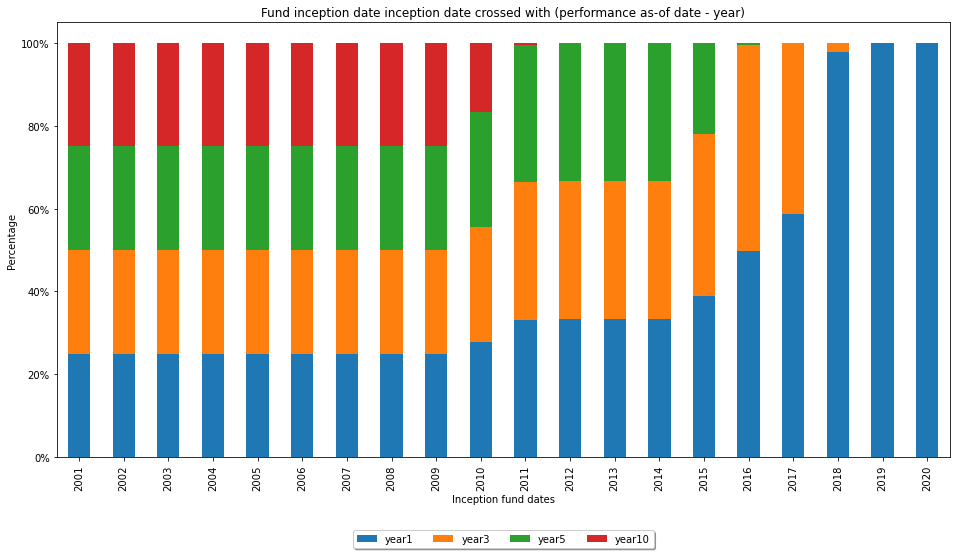

In [20]:
perf_date=pd.DataFrame()
for year in [1,3,5,10]:
    filter_df=df['Fund profile: Shareclass inception date'][( (df['Financial performance: Financial performance as-of date'] - pd.DateOffset(years=year)) > df['Fund profile: Shareclass inception date']  )]
    perf_date["year"+str(year)] =filter_df.groupby(filter_df.dt.year).count()

#Normalize row perf_data by year
perf_date_norm=perf_date.div(perf_date.sum(axis=1), axis=0)*100
perf_date_norm.loc['2000-1-1 00:00:00':'2022-1-1 00:00:00'].plot.bar(figsize=(16, 8), stacked=True)

#Plot properties
plt.xlabel("Inception fund dates")
plt.ylabel("Percentage")
plt.title("Fund inception date inception date crossed with (performance as-of date - year)")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22),
          ncol=4, fancybox=True, shadow=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
#plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


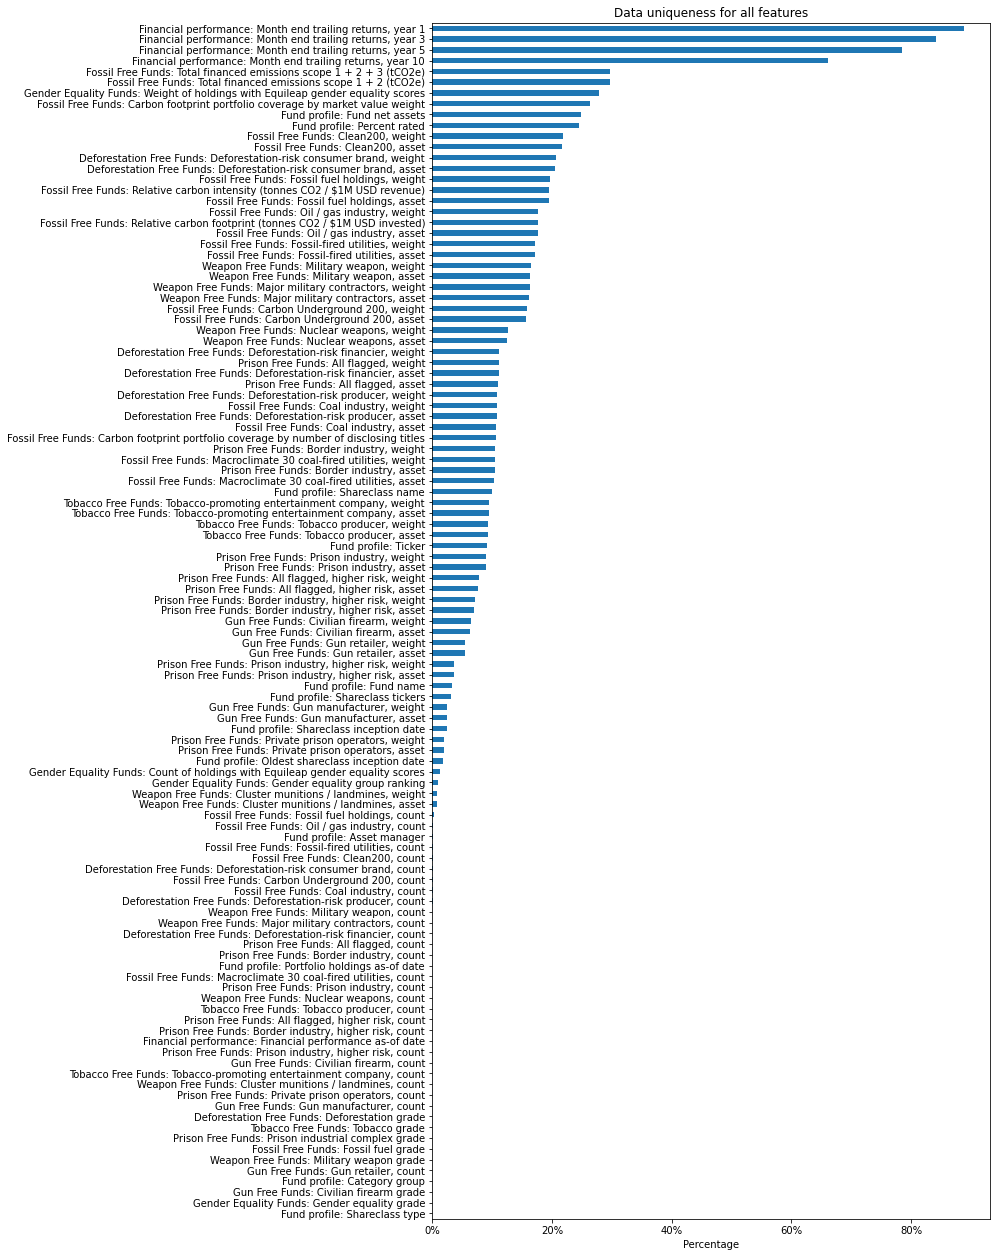

In [21]:
columns_stats=pd.DataFrame()
columns_stats['unique_values']=df.nunique()/len(df)*100
fig = plt.figure(figsize=(10, 22))
columns_stats['unique_values'].sort_values().plot.barh()
plt.title("Data uniqueness for all features")
plt.xlabel("Percentage")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()


In [27]:
df.nunique()/len(df)*100

Fund profile: Shareclass name                              9.996380
Fund profile: Ticker                                       9.096009
Fund profile: Fund name                                    3.275722
Fund profile: Asset manager                                0.191838
Fund profile: Shareclass type                              0.001810
                                                             ...   
Prison Free Funds: Border industry, higher risk, weight    7.098905
Prison Free Funds: Border industry, higher risk, asset     7.021084
Prison Free Funds: Private prison operators, count         0.007239
Prison Free Funds: Private prison operators, weight        2.062257
Prison Free Funds: Private prison operators, asset         2.043254
Length: 111, dtype: float64